In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 5s 128ms/step - loss: 0.0231 - val_loss: 0.0104
Epoch 2/100
16/16 [==============================] - 1s 50ms/step - loss: 0.0047 - val_loss: 6.5380e-04
Epoch 3/100
16/16 [==============================] - 1s 52ms/step - loss: 9.7893e-04 - val_loss: 4.6526e-04
Epoch 4/100
16/16 [==============================] - 1s 53ms/step - loss: 5.6531e-04 - val_loss: 4.0217e-04
Epoch 5/100
16/16 [==============================] - 1s 51ms/step - loss: 5.1057e-04 - val_loss: 3.8206e-04
Epoch 6/100
16/16 [==============================] - 1s 52ms/step - loss: 4.8607e-04 - val_loss: 3.6950e-04
Epoch 7/100
16/16 [==============================] - 1s 53ms/step - loss: 4.6506e-04 - val_loss: 3.6360e-04
Epoch 8/100
16/16 [==============================] - 1s 50ms/step - loss: 4.4985e-04 - val_loss: 3.7810e-04
Epoch 9/100
16/16 [==============================] - 1s 52ms/step - loss: 4.5316e-04 - val_loss: 3.5763e-04
Epoch 10/100
16/16 [===================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 16ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16372.551187386902


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.9984926546532
Testing MAE: 16028.091653380845


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.32800614833831787], [0.33065372705459595], [0.3332349359989166], [0.33571240305900574], [0.33812621235847473], [0.3405020534992218], [0.3428533971309662], [0.3451884686946869], [0.34751343727111816], [0.34983304142951965], [0.3521507680416107], [0.35446953773498535], [0.3567914366722107], [0.35911825299263], [0.36145132780075073], [0.36379173398017883], [0.36614030599594116], [0.36849766969680786], [0.3708644211292267], [0.37324100732803345], [0.37562763690948486], [0.3780245780944824], [0.38043203949928284], [0.3828500509262085], [0.3852788507938385], [0.3877182602882385], [0.39016851782798767], [0.3926295340061188], [0.39510127902030945], [0.39758363366127014], [0.40007659792900085], [0.402580201625824], [0.4050942659378052], [0.40761876106262207], [0.4101535379886627], [0.4126983880996704], [0.41525328159332275], [0.4178180396556854], [0.4203927218914032], [0.4229769706726074], [0.4255707263946533], [0.4281737804412842], [0.43078601360321045], [0.433407187461853], [0.43603715300

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[19862.92120055],
       [19968.85320781],
       [20072.12970076],
       [20171.25538755],
       [20267.83407005],
       [20362.89361235],
       [20456.97298727],
       [20550.4013021 ],
       [20643.42538731],
       [20736.23483733],
       [20828.96916504],
       [20921.74522736],
       [21014.64649355],
       [21107.74450866],
       [21201.0929315 ],
       [21294.73468911],
       [21388.70316917],
       [21483.02341247],
       [21577.71926736],
       [21672.8086201 ],
       [21768.29981762],
       [21864.20359168],
       [21960.5282892 ],
       [22057.2751026 ],
       [22154.45357123],
       [22252.05654057],
       [22350.09354996],
       [22448.56102217],
       [22547.45776475],
       [22646.77900806],
       [22746.52475208],
       [22846.69618923],
       [22947.28616501],
       [23048.293487  ],
       [23149.71219311],
       [23251.53393642],
       [23353.7575245 ],
       [23456.37580286],
       [23559.39115632],
       [23662.78927588],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(466,)


(466, 1)

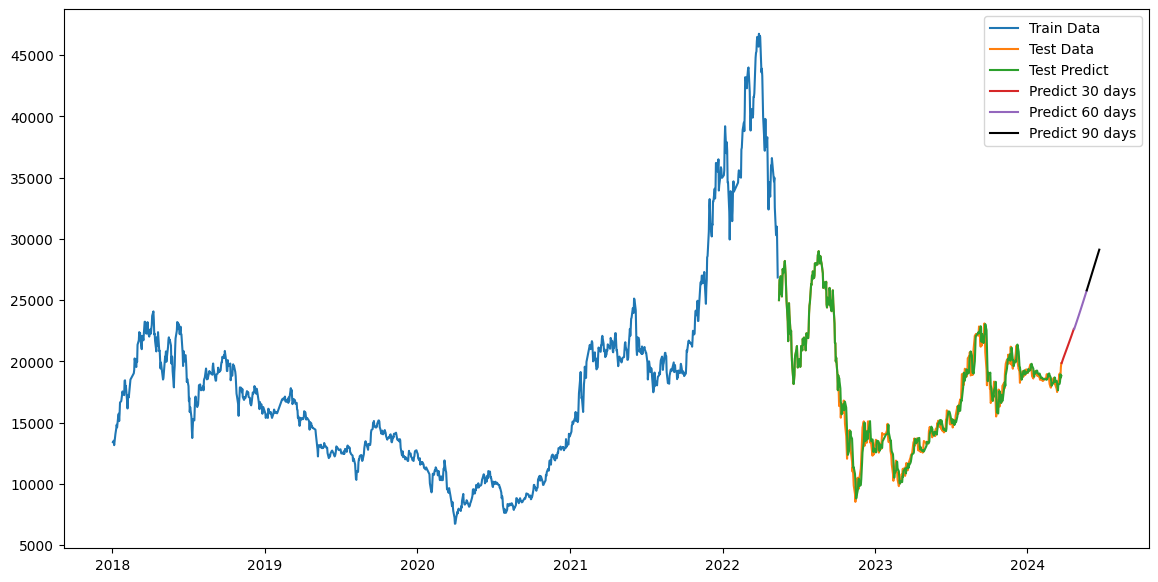

In [20]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()